In [2]:
pip install pandas numpy seaborn matplotlib sqlalchemy psycopg2

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install postgresql


ERROR: Could not find a version that satisfies the requirement postgresql (from versions: none)
ERROR: No matching distribution found for postgresql
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install psycopg2-binary


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [7]:
#для доступа к бд
DB_TYPE = 'postgresql'
DB_HOST='project-for-love-sikalovaes.db-msk0.amvera.tech'
DB_PORT='5432'
DB_NAME='dblove'
DB_USER='admin'
DB_PASSWORD='YFIk.,jdysqghjtrn3'

engine = create_engine(f'{DB_TYPE}://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?client_encoding=utf9')



In [18]:
!pip install psycopg2



  Using cached psycopg2-2.9.10.tar.gz (385 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.10-cp311-cp311-macosx_10_9_universal2.whl size=241925 sha256=8b77eb481360bd68783bd6dcf14fd33b50d0f15a330a4e4e503d46c3ae74e81f
  Stored in directory: /Users/a79892/Library/Caches/pip/wheels/d9/83/60/e9660320860aef3c38a67dea6ff9538e4cad76502cb39ed280
Successfully built psycopg2


In [24]:

query = f'''
SELECT action_from, time 
FROM public.tg_users_group_message
'''
df = pd.read_sql(query, engine)

df

OperationalError: (psycopg2.OperationalError) connection to server at "project-for-love-sikalovaes.db-msk0.amvera.tech" (51.250.35.206), port 5432 failed: received invalid response to GSSAPI negotiation: H

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [2]:
df = pd.read_csv('tg_users_groups_actions_202412022343.csv')
df

,id,chat_id,action,action_from,action_to,reply_on_id,reply_on_chat_id,message_id,message_chat_id,time,created_at
0,2191,-1001489613436,message,1309325426,NaN,NaN,NaN,24701,-1001489613436,2024-08-19 17:01:37.000 +0300,2024-11-25 19:35:49.489
1,2192,-1001489613436,message,1309325426,NaN,NaN,NaN,24700,-1001489613436,2024-08-19 17:01:30.000 +0300,2024-11-25 19:35:49.594
2,4,1,message,11,NaN,NaN,NaN,12,1,2023-10-25 15:30:00.000 +0300,2024-11-25 15:14:19.284
3,8,-1002462279841,message,374150300,NaN,NaN,NaN,26,-1002462279841,2024-11-18 21:32:07.000 +0300,2024-11-25 18:59:12.059
4,9,-1002462279841,message,374150300,NaN,NaN,NaN,25,-1002462279841,2024-11-18 21:17:46.000 +0300,2024-11-25 18:59:12.422
...,...,...,...,...,...,...,...,...,...,...,...
14769,17110,-1001263827769,message,7775240024,NaN,NaN,NaN,24409338,-1001263827769,2024-12-02 13:50:02.000 +0300,2024-12-02 20:27:54.905
14770,17111,-1001263827769,message,7504944020,NaN,NaN,NaN,24409337,-1001263827769,2024-12-02 13:50:00.000 +0300,2024-12-02 20:27:55.039
14771,17112,-1001263827769,message,7723360933,NaN,NaN,NaN,24409336,-1001263827769,2024-12-02 13:50:00.000 +0300,2024-12-02 20:27:55.481
14772,17113,-1001263827769,message,7146830509,NaN,NaN,NaN,24409334,-1001263827769,2024-12-02 13:49:40.000 +0300,2024-12-02 20:27:55.620


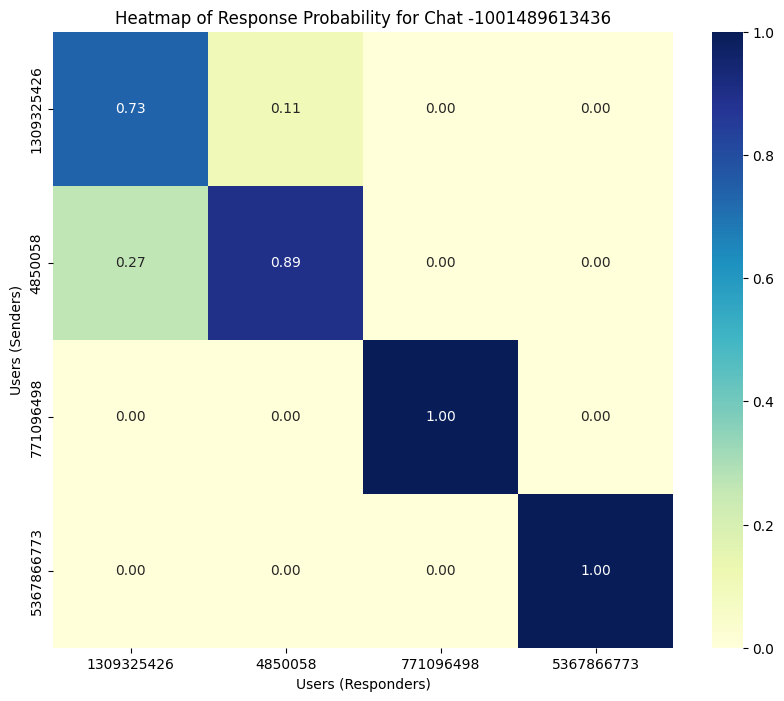

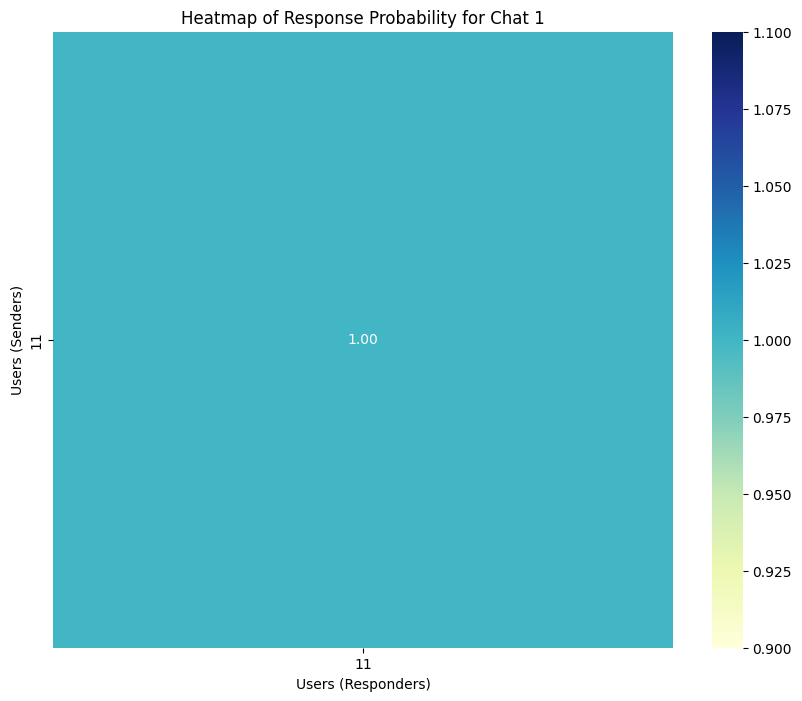

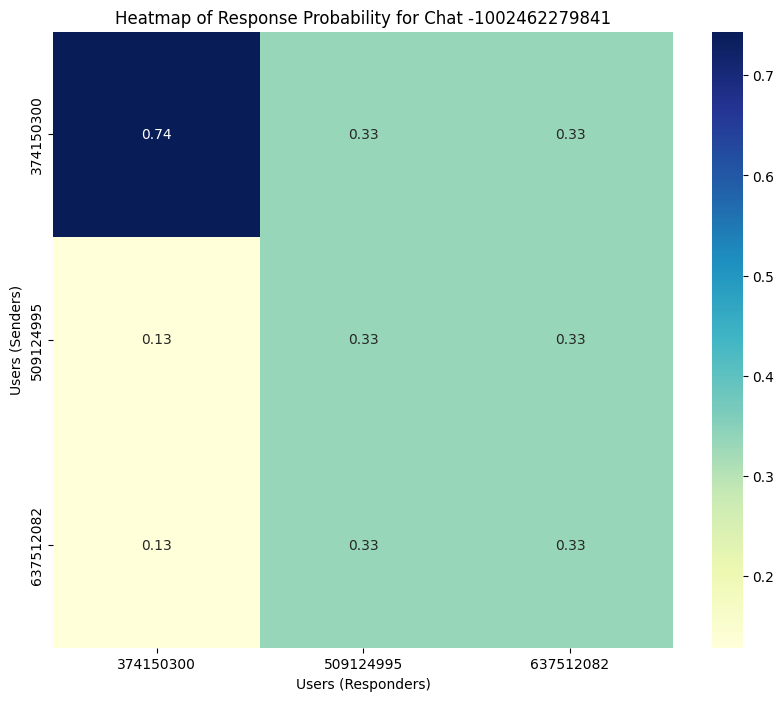

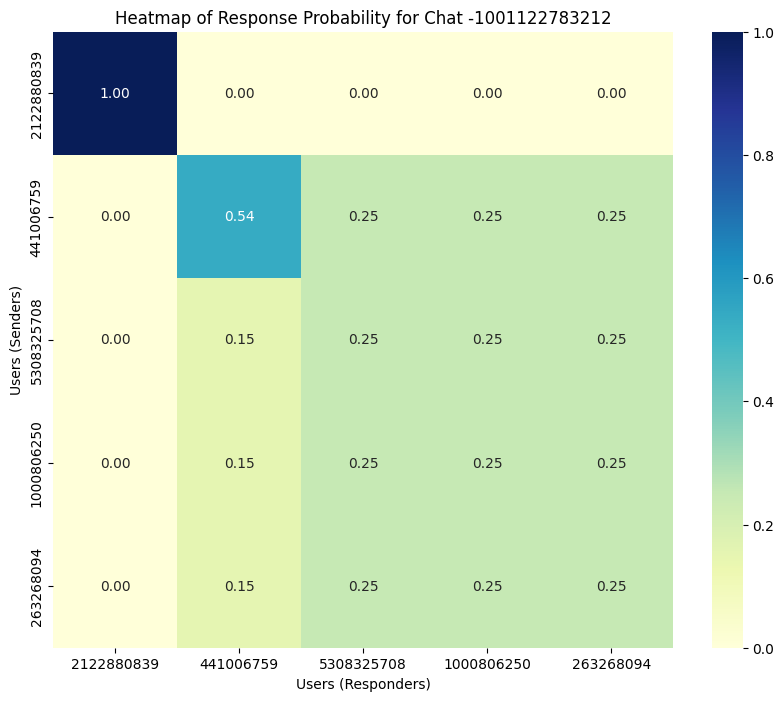

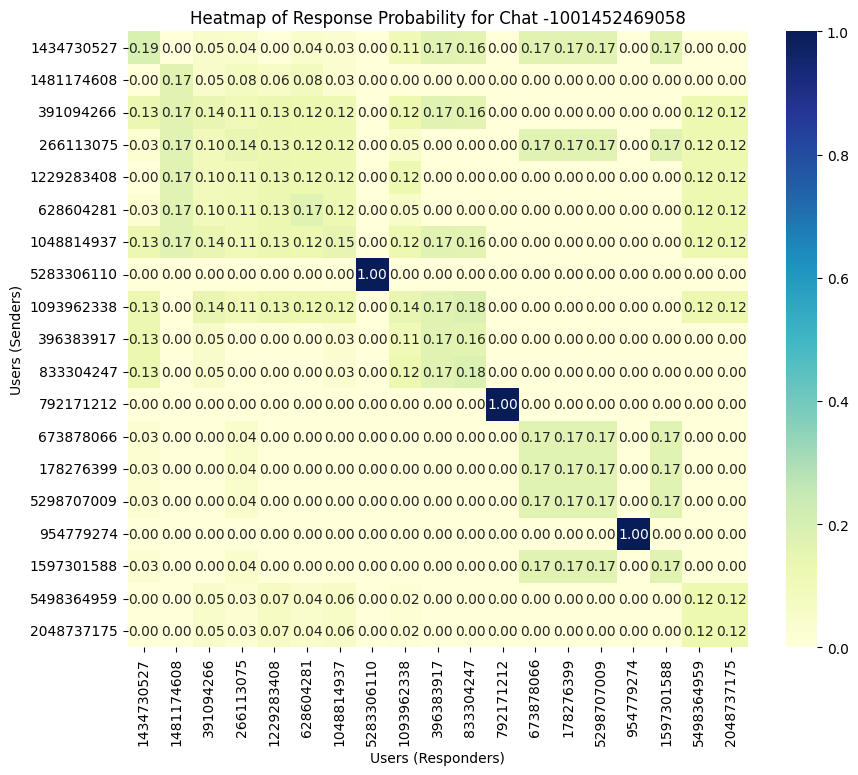

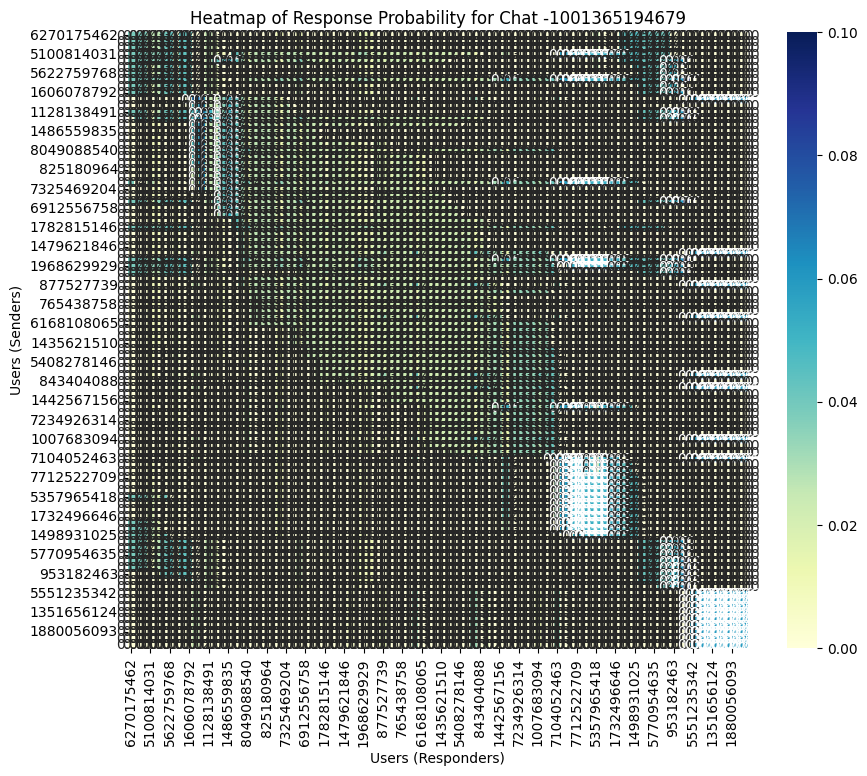

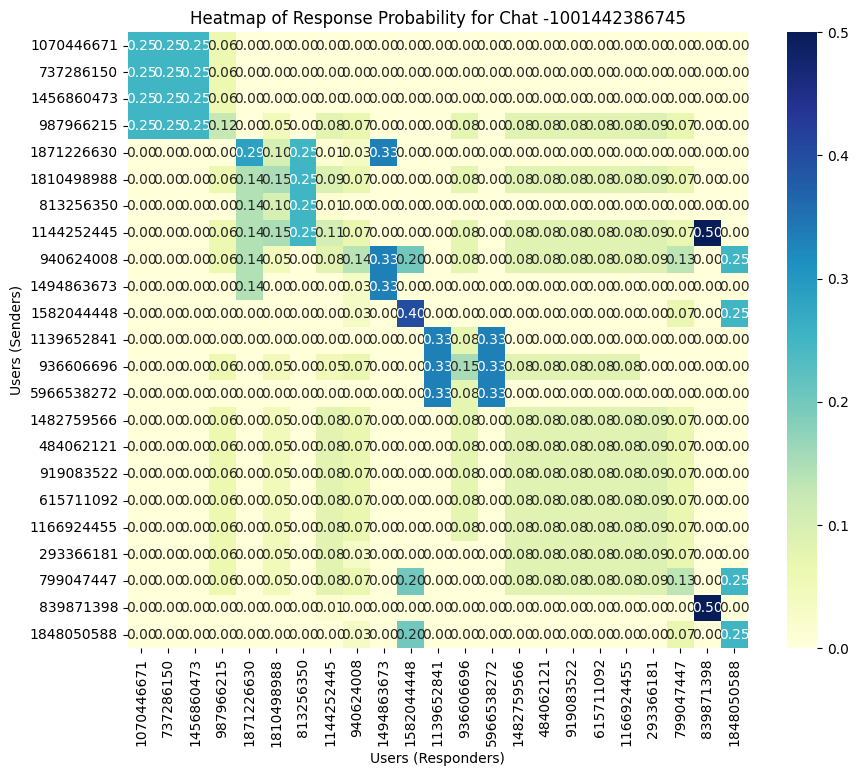

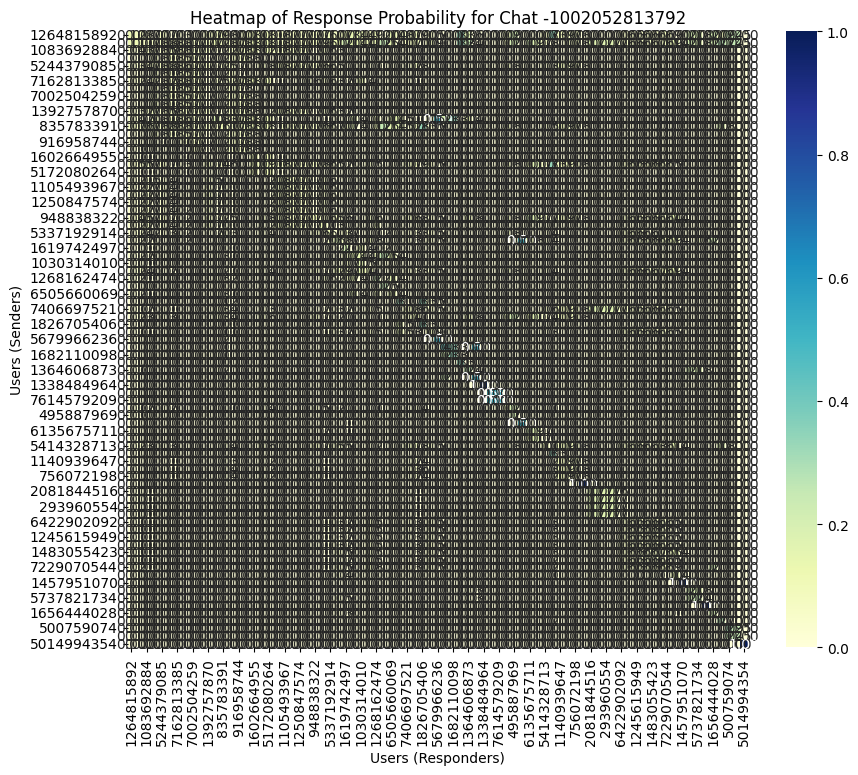

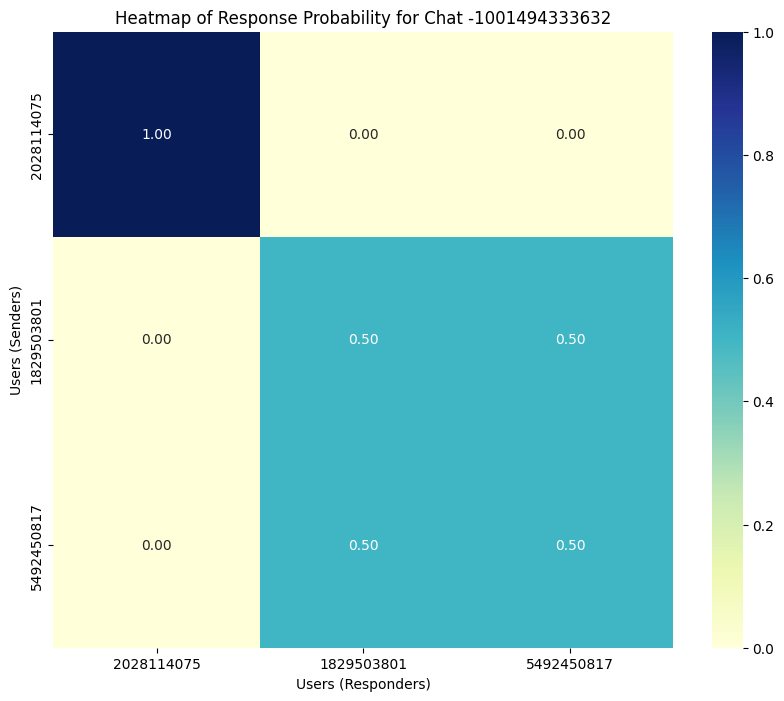

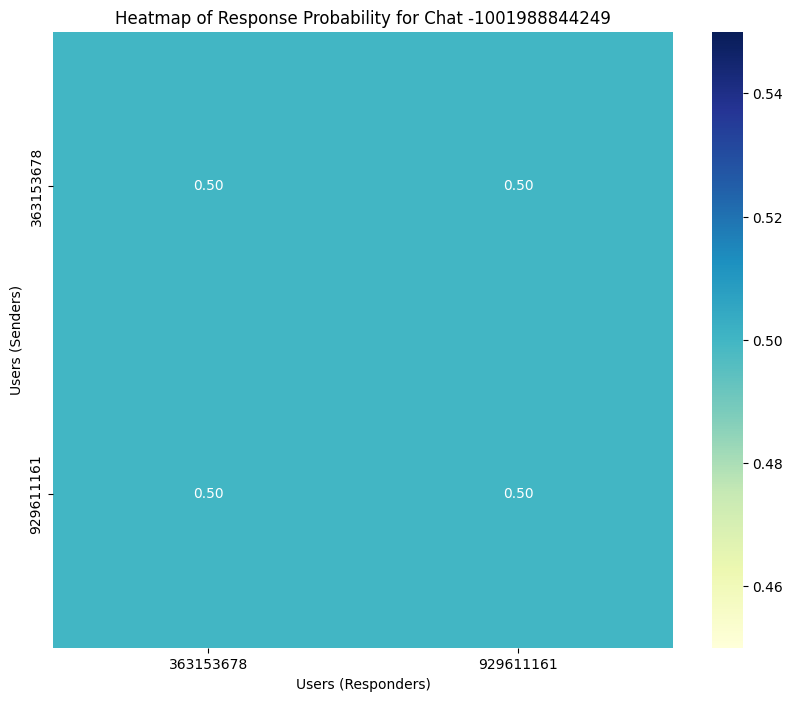

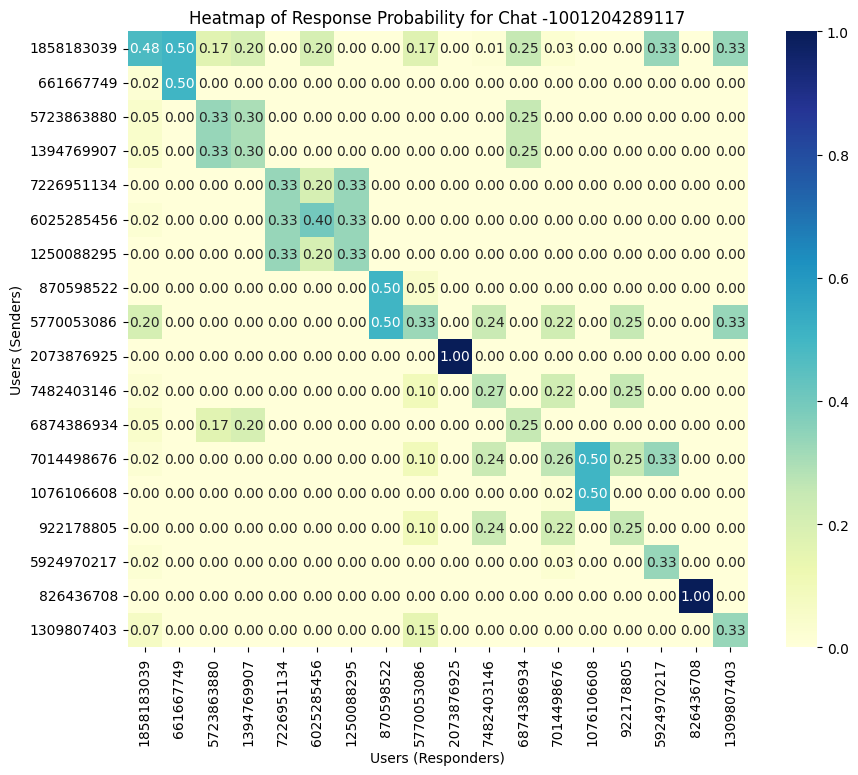

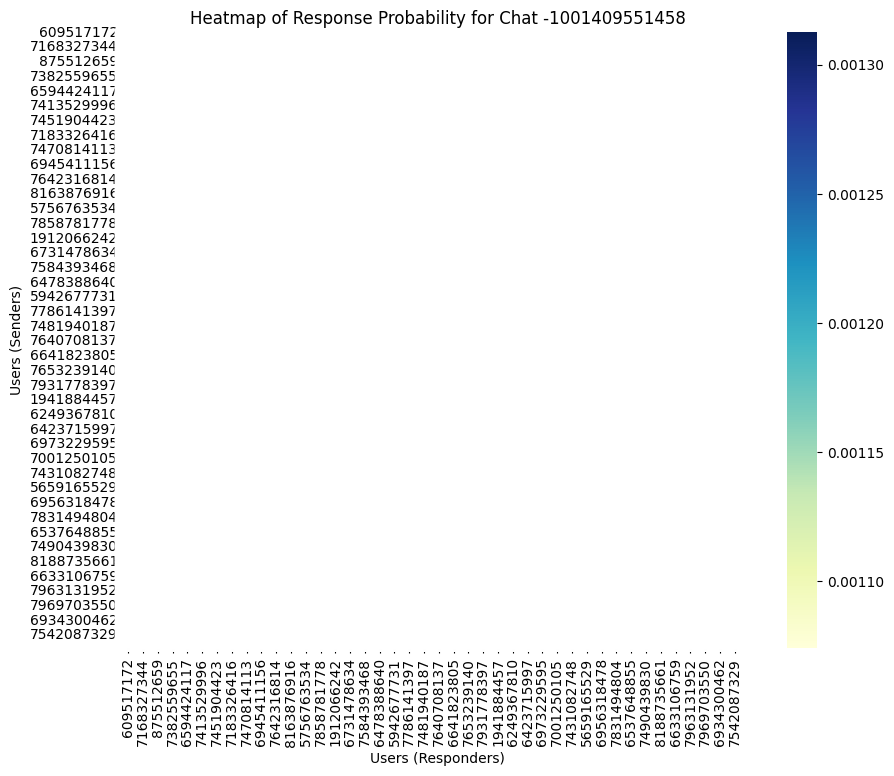

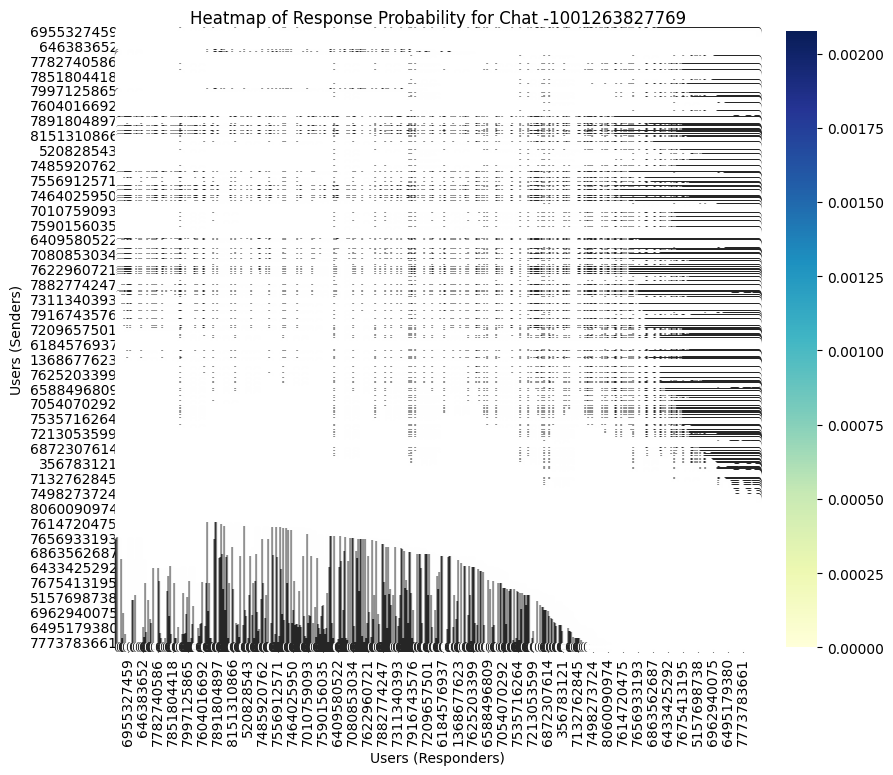

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['time'] = pd.to_datetime(df['time'])

time_window = pd.Timedelta('5 hours')

for chat in df['chat_id'].unique():
    chat_messages = df[df['chat_id'] == chat]
    unique_users = df['action_from'].unique()
    probabilities_matrix = pd.DataFrame(0, index=unique_users, columns=unique_users)

    for user in unique_users:
        user_messages = chat_messages[chat_messages['action_from'] == user]
        for message_time in user_messages['time']:
            replies_within_window = chat_messages[
                (chat_messages['time'] > message_time - time_window) &
                (chat_messages['time'] <= message_time + time_window)]

            probabilities_matrix.loc[replies_within_window['action_from'], user] += 1

    # Нормализация
    probabilities_matrix = probabilities_matrix.div(probabilities_matrix.sum(axis=0), axis=1)
    
    probabilities_matrix = probabilities_matrix.loc[(probabilities_matrix.sum(axis=1) > 0), 
                                                    (probabilities_matrix.sum(axis=0) > 0)]


    if probabilities_matrix.empty:
        print(f'No interactions for chat {chat}. Skipping heatmap.')
        continue

    plt.figure(figsize=(10, 8))
    sns.heatmap(probabilities_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
    plt.title(f'Heatmap of Response Probability for Chat {chat}')
    plt.xlabel('Users (Responders)')
    plt.ylabel('Users (Senders)')
    plt.show()
